In [12]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/neverworld2_1.0deg_nlev37/'

save_path         = None # '/albedo/home/pscholz/tripyview/Results/check_neverworld2/' #None # '/albedo/home/pscholz/tripyview/Results/test_newploting/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/home/pscholz/results/test_channel_ctrl_01/1/')
input_paths.append('/albedo/scratch/user/pscholz/test_neverworld2_1.00deg_nlev37_Tperturb/1/')

input_names= list()
input_names.append('neverworld2')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1970, 1970]
mon       = None
day       = None
record    = -1 #None
box       = [0.0-2.0, 60.0+2.0, -70.0-2.0, 70.0+2.0] # neverworld box + margin for lsmask of width 2.0 deg
depth     = 10

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#_____________________________________________________________________________________
do_clim   = False
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'neverworld2'
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            = 'neverworld2'  # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [14]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

In [46]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, cyclic=60, do_info=True, do_lsmask=False)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'}) 

# if client is not None:
#     # set size limit of time chunks so that size of the total chunks covers 10% of worker memory
#     mem_thresh     = 0.08
#     worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
#     mem_limit_byte = next(iter(worker_info.items()))[1]
#     print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
#     print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
#     chunk_size = mem_limit_byte * mem_thresh/4 # dive by 4 because we use 4byte single precision
#     if   chunks['nod2'] != 'auto': chunk_size = chunk_size/chunks['nod2']    
#     elif chunks['elem'] != 'auto': chunk_size = chunk_size/chunks['elem']
#     if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
#     elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
#     chunks['time'] = np.int32(np.ceil(chunk_size))
#     print(' --> set time chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['time']))

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/neverworld2_1.0deg_nlev37
 > load  *.jlib file: tripyview_mesh_neverworld2_1.0deg_nlev37_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/neverworld2_1.0deg_nlev37
 > id              = neverworld2_1.0deg_nlev37
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = False
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 8578
 > #elem           = 16798
 > #lvls           = 38
___________________________________________


0 /albedo/scratch/user/pscholz/test_neverworld2_1.00deg_nlev37_Tperturb/1/ neverworld2
neverworld2 [-2.0, 62.0, -72.0, 72.0]
{'cstr': 'blue2red', 'cnum': 25, 'chist': True, 'ctresh': 0.995, 'cref': np.int64(0), 'crange': [-3.0, 1.0, 0], 'cnlab': 8, 'cmin': -3.0, 'cmax': 1.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x155075d756a0>, 'clevel': array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
       -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
       -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,
        0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), 'clab': array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6])}
 > save figure: /albedo/home/pscholz/tripyview/Results/check_neverworld2/ssh_channel_neverworld2_y1970-1970_rec_-1.png


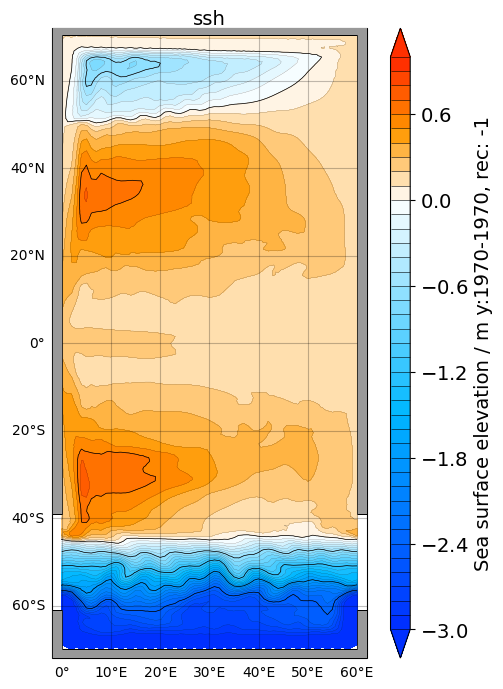

In [47]:
vname     = 'ssh'
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=vname, do_info=False, do_file='run', do_parallel=do_parallel) 
    #__________________________________________________________________________________________________    
    data_list.append(data)  
    del(data)

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
ndat   = len(data_list)

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()                                                         
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_channel_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

cinfo0.update({'cnum':25, 'cref':0, 'crange':[-3.0, 1.0 ,0]})
#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=True, plt_contf=True, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(), do_mesh=do_mesh, do_lsm=do_lsm, 
                                do_save=sfpath, save_dpi=save_dpi)  

0 /albedo/scratch/user/pscholz/test_neverworld2_1.00deg_nlev37_Tperturb/1/ neverworld2
neverworld2 [-2.0, 62.0, -72.0, 72.0]
--> cmin/cmax: fin: 8.471004/26.328999
{'cstr': 'cmocean.thermal', 'cnum': 25, 'chist': False, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(8.47), 'cmax': np.float64(26.33), 'cref': np.float64(17.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x155076fd9be0>, 'clevel': array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. ,
       13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5,
       19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. ,
       24.5, 25. , 25.5, 26. , 26.5]), 'clab': array([ 9.5, 12. , 14.5, 17. , 19.5, 22. , 24.5])}
 > save figure: /albedo/home/pscholz/tripyview/Results/check_neverworld2/temp_channel_neverworld2_y1970-1970_rec_-1_dep10-10m.png


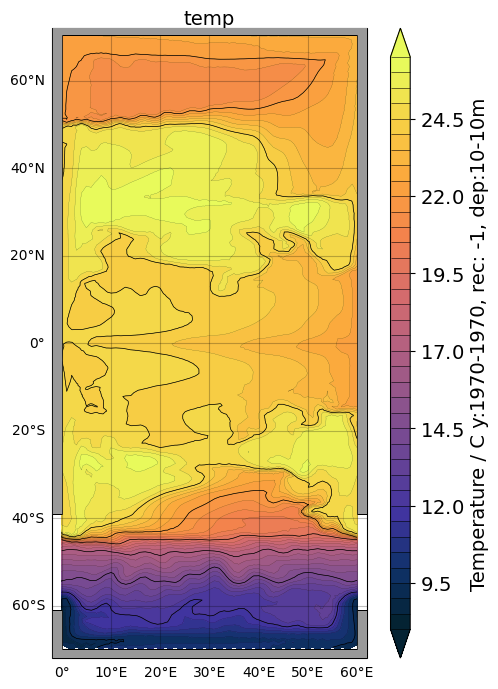

In [48]:
depth     = [10]
vname     = 'temp'
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=vname, do_info=False, do_file='run', do_parallel=do_parallel) 
    #__________________________________________________________________________________________________    
    data_list.append(data)  
    del(data)
    
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
ndat   = len(data_list)

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_channel_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
cinfo0.update({'cstr':'cmocean.thermal', 'chist':False, 'cnum':25})    

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt='tcf', plt_contb=True, plt_contf=True, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(), do_mesh=do_mesh, do_lsm=do_lsm, 
                                do_save=sfpath, save_dpi=save_dpi)  

0 /albedo/scratch/user/pscholz/test_neverworld2_1.00deg_nlev37_Tperturb/1/ neverworld2
neverworld2 [-2.0, 62.0, -72.0, 72.0]
{'cstr': 'cmocean.curl', 'cnum': 25, 'chist': False, 'ctresh': 0.995, 'crange': [-5e-06, 5e-06, 0.0], 'cnlab': 8, 'cmin': -5e-06, 'cmax': 5e-06, 'cref': np.float64(0.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x155075d04040>, 'clevel': array([-5.25e-06, -5.00e-06, -4.75e-06, -4.50e-06, -4.25e-06, -4.00e-06,
       -3.75e-06, -3.50e-06, -3.25e-06, -3.00e-06, -2.75e-06, -2.50e-06,
       -2.25e-06, -2.00e-06, -1.75e-06, -1.50e-06, -1.25e-06, -1.00e-06,
       -7.50e-07, -5.00e-07, -2.50e-07,  0.00e+00,  2.50e-07,  5.00e-07,
        7.50e-07,  1.00e-06,  1.25e-06,  1.50e-06,  1.75e-06,  2.00e-06,
        2.25e-06,  2.50e-06,  2.75e-06,  3.00e-06,  3.25e-06,  3.50e-06,
        3.75e-06,  4.00e-06,  4.25e-06,  4.50e-06,  4.75e-06,  5.00e-06,
        5.25e-06]), 'clab': array([-4.5e-06, -3.0e-06, -1.5e-06,  0.0e+00,  1.5e-06,  3.0e-06,
        4.5e-06])}
 

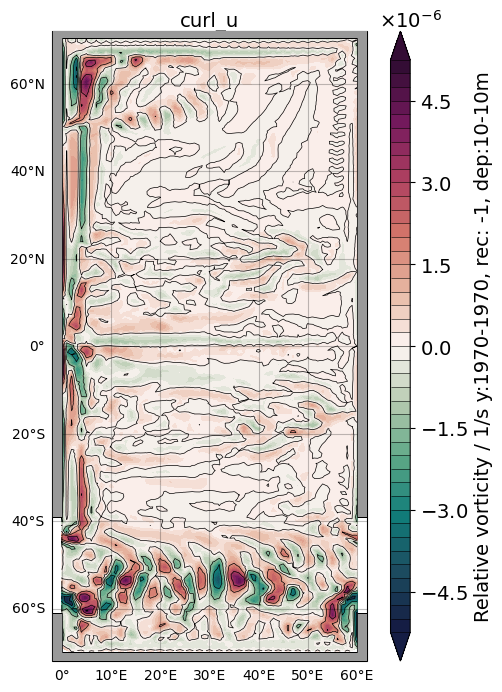

In [49]:
depth     = [10]
vname     = 'curl_u'
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=vname, do_info=False, do_file='run', do_parallel=do_parallel) 
    #__________________________________________________________________________________________________    
    data_list.append(data)  
    del(data)
    
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
ndat   = len(data_list)

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_channel_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
cinfo0.update({'cstr':'cmocean.curl', 'chist':False, 'cnum':25, 'crange':[-5.0e-6, 5.0e-6, 0.0]})    

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt='tcf', plt_contb=False, plt_contf=True, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(), do_mesh=do_mesh, do_lsm=do_lsm, 
                                do_save=sfpath, save_dpi=save_dpi)  

## Make Neverworld2 movie:
save each frame as *.png than ...

ffmpeg -pattern_type glob -r 1 -i 'frame_*.png' -c:v libx264 -pix_fmt yuv420p -vf scale=1440:992 movie.mp4  <br>
ffmpeg -i movie.mp4 -r 6 -filter:v "setpts=PTS/6" movie_x6.mp4<br>
ffmpeg -stream_loop 5 -i movie_x6.mp4 -c copy movie_x6_loop5.mp4


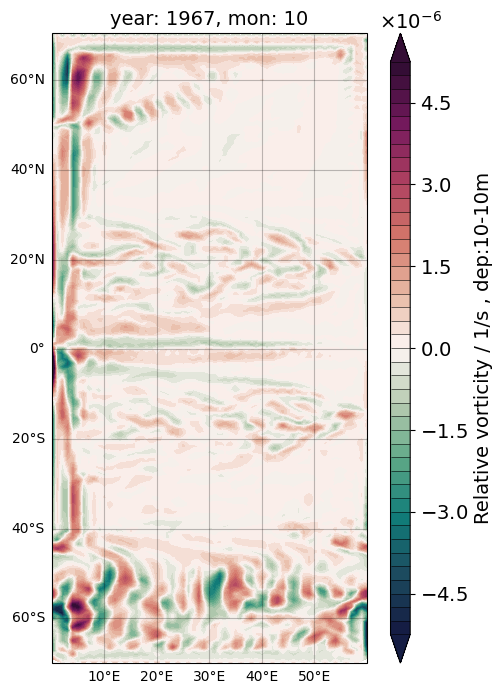

year:  1967, rec:    10, cnt:   118


In [ ]:
import matplotlib.pyplot        as plt
import time
from IPython.display import display, clear_output
plt.ion()  # interactive mode

vname     = 'curl_u'
data_list = list()
year      = [1958, 1993]
# record    = [0, 365]#[0, 221]
record    = [0, 12]#[0, 221]
depth     = [10]
save_path_mov = '/albedo/home/pscholz/tripyview/Results/check_neverworld2/movie/'
do_plt   = 'tcf'
which_dpi = 150

#___LOAD FESOM2 DATA___________________________________________________________________________________
cnt = 0
for yeari in range(year[0], year[1]+1):
    for reci in range(record[0], record[1]):
        
        #______________________________________________________________________________________________
        data = tpv.load_data_fesom2(mesh, input_paths[0], vname=vname, year=[yeari, yeari], mon=mon, day=day, record=reci, 
                                    depth=depth, descript=vname, do_info=False) 
        data[vname].attrs['str_ltim']=''
        
        #___PLOT FESOM2 DATA___________________________________________________________________________
#         cinfo0 = dict({'cstr':'cmocean.balance', 'crange':[-3.0, 1.0, 0], 'cnum':40})
#         cinfo0 = dict({'cstr':'blue2red', 'crange':[-3.0, 1.0, 0], 'cnum':30})
        cinfo0 = dict({'cstr':'cmocean.curl', 'crange':[-5e-6, 5e-6, 0], 'cnum':30})
        spath  = os.path.join(save_path_mov,'{}_{:04d}_{:04d}.png'.format('frame', yeari, reci))

        #______________________________________________________________________________________________
        if cnt==0 :
            fig, hax, hcb, hall, tri, cinfo_plot = tpv.plot_hslice(mesh, [data], cinfo=cinfo0, box=box, nrow=1, ncol=1, proj=proj, do_rescale=False,  
                                                                do_plt=do_plt, plt_contb=False, plt_contf=False, plt_contr=False, plt_contl=False, do_enum=False, 
                                                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(), do_mesh=do_mesh, do_lsm=do_lsm, 
                                                                do_save=None, nargout=['hfig', 'hax', 'hcb', 'hall', 'tri', 'cinfo_plot'])  
            tpv.do_savefigure(spath, fig, dpi=save_dpi, do_info=False)    
        
        #______________________________________________________________________________________________
        else:
            data_plot = data[vname].values.copy()
            data_plot = np.hstack((data_plot,data_plot[mesh.n_pbnd_a]))
            hall[0].remove()
            hall = []
            if do_plt=='tcp':
                hp=hax[ii].tripcolor(tri.x, tri.y, tri.triangles[tri.mask_e_ok,:], data_plot,
                                     shading='flat', cmap=cinfout['cmap'],
                                     vmin=cinfo_plot[0]['clevel'][0], vmax=cinfo_plot[0]['clevel'][ -1],)
            elif do_plt=='tcf': 
                hp=hax[ii].tricontourf(tri.x, tri.y, tri.triangles[tri.mask_e_ok,:], data_plot,
                                       levels=cinfo_plot[0]['clevel'], cmap=cinfo_plot[0]['cmap'], extend='both',)
            
            hall.append(hp)
                                
#             hax[0].set_title('year: {:4d}, day: {:03d}'.format(yeari, reci+1), fontsize=14)
            hax[0].set_title('year: {:4d}, mon: {:02d}'.format(yeari, reci+1), fontsize=14)
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            
            # clear previous output
            clear_output(wait=True)
            
            #render new output
            display(fig)
            tpv.do_savefigure(spath, fig, dpi=which_dpi, do_info=False) 
            
        cnt = cnt+1
        print('year: {:5d}, rec: {:5d}, cnt: {:5d}'.format(yeari, reci+1, cnt))

In [10]:
dir(mesh)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'abg',
 'augment_lsmask',
 'cachepath',
 'compute_e_area',
 'compute_e_nghbr_e',
 'compute_e_resol',
 'compute_lsmask',
 'compute_n_area',
 'compute_n_nghbr_e',
 'compute_n_nghbr_n',
 'compute_n_resol',
 'cyclic',
 'do_augmpbnd',
 'do_cavity',
 'do_earea',
 'do_eresol',
 'do_f14cmip6',
 'do_loadraw',
 'do_lsmask',
 'do_lsmshp',
 'do_narea',
 'do_nresol',
 'do_rot',
 'e_area',
 'e_i',
 'e_ia',
 'e_ic',
 'e_iz',
 'e_nghbr_e',
 'e_pbnd_0',
 'e_pbnd_1',
 'e_pbnd_a',
 'e_resol',
 'fname_aux3d',
 'fname_celvls',
 'fname_cnlvls',
 'fname_elem2d',
 'fname_elvls',
 'fname_elvls_raw',
 'fname_nlvls',
 'fname_nod2d',
 'focus',
 'foc